### 数据导入和预处理

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import warnings

# 过滤sklearn的数值计算警告
warnings.filterwarnings('ignore', category=RuntimeWarning, module='sklearn')
warnings.filterwarnings('ignore', category=RuntimeWarning, module='numpy')

In [24]:
# 读取已清理的数据
df_heart = pd.read_csv("cleaned_heart.csv")

# 对分类变量进行One-Hot编码
df_heart = pd.get_dummies(df_heart, columns=[
    'Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS'
], drop_first=True)

# 将目标变量转换为数值格式
le = LabelEncoder()
df_heart['HeartDisease'] = le.fit_transform(df_heart['HeartDisease'])
print(f"目标变量映射: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 分离特征和目标变量
X = df_heart.drop('HeartDisease', axis=1)
y = df_heart['HeartDisease']

# 确保数据类型正确
X = X.astype('float64')

# 数值稳定性检查
X = X.replace([np.inf, -np.inf], np.nan)
if X.isnull().any().any():
    X = X.fillna(X.median())

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 使用RobustScaler进行特征缩放
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 将缩放后的数据转换回DataFrame格式
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

目标变量映射: {'No': np.int64(0), 'Yes': np.int64(1)}


In [25]:
# 构建逻辑回归模型
model = LogisticRegression(
    random_state=42,
    solver='lbfgs',
    C=1.0,
    max_iter=2000
)

# 训练模型
model.fit(X_train_scaled, y_train)

# 模型预测
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 模型评估
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)

print(f"\n--- Heart Disease Prediction Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:\n", class_report)

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Heart Disease Prediction')
plt.legend(loc='lower right')
plt.savefig("heart_roc_curve.png", dpi=300, bbox_inches='tight')
plt.close()

# 特征重要性分析
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)


--- Heart Disease Prediction Model Evaluation ---
Accuracy: 0.8913
ROC AUC: 0.9334
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [26]:
# 随机森林模型
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Random Forest - Accuracy: {rf_accuracy:.4f}, ROC AUC: {rf_roc_auc:.4f}")

# 特征重要性
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance.head(10))

Random Forest - Accuracy: 0.8478, ROC AUC: 0.9247
Random Forest Feature Importance:
               Feature  Importance
13         ST_Slope_Up    0.198940
12       ST_Slope_Flat    0.152213
4              Oldpeak    0.114999
3                MaxHR    0.099089
11  ExerciseAngina_Yes    0.085563
0                  Age    0.067072
2          Cholesterol    0.064544
1            RestingBP    0.057500
6    ChestPainType_ATA    0.039073
5                Sex_M    0.036981


In [27]:
# SVM模型
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_roc_auc = roc_auc_score(y_test, svm_pred_proba)

print(f"SVM - Accuracy: {svm_accuracy:.4f}, ROC AUC: {svm_roc_auc:.4f}")

SVM - Accuracy: 0.8478, ROC AUC: 0.9358


In [28]:
# 梯度提升模型
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

gb_accuracy = accuracy_score(y_test, gb_pred)
gb_roc_auc = roc_auc_score(y_test, gb_pred_proba)

print(f"Gradient Boosting - Accuracy: {gb_accuracy:.4f}, ROC AUC: {gb_roc_auc:.4f}")

gb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Gradient Boosting Feature Importance (Top 10):")
print(gb_importance.head(10))

Gradient Boosting - Accuracy: 0.8804, ROC AUC: 0.9225
Gradient Boosting Feature Importance (Top 10):
                    Feature  Importance
13              ST_Slope_Up    0.509725
4                   Oldpeak    0.097396
3                     MaxHR    0.082177
2               Cholesterol    0.057528
5                     Sex_M    0.044909
7         ChestPainType_NAP    0.041596
11       ExerciseAngina_Yes    0.033526
1                 RestingBP    0.032022
0                       Age    0.030950
14  FastingBS_Normal (≤120)    0.026509


In [29]:
# KNN模型
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean'
)

knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)
knn_pred_proba = knn_model.predict_proba(X_test_scaled)[:, 1]

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_roc_auc = roc_auc_score(y_test, knn_pred_proba)

print(f"KNN - Accuracy: {knn_accuracy:.4f}, ROC AUC: {knn_roc_auc:.4f}")

KNN - Accuracy: 0.8750, ROC AUC: 0.9369


In [30]:
# LightGBM模型
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    num_leaves=31,
    random_state=42,
    objective='binary',
    metric='binary_logloss',
    verbose=-1  # 减少输出信息
)

lgb_model.fit(X_train_scaled, y_train)
lgb_pred = lgb_model.predict(X_test_scaled)
lgb_pred_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]

lgb_accuracy = accuracy_score(y_test, lgb_pred)
lgb_roc_auc = roc_auc_score(y_test, lgb_pred_proba)

print(f"LightGBM - Accuracy: {lgb_accuracy:.4f}, ROC AUC: {lgb_roc_auc:.4f}")

# LightGBM特征重要性
lgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("LightGBM Feature Importance (Top 10):")
print(lgb_importance.head(10))

LightGBM - Accuracy: 0.8533, ROC AUC: 0.9132
LightGBM Feature Importance (Top 10):
               Feature  Importance
3                MaxHR         364
2          Cholesterol         318
4              Oldpeak         258
0                  Age         257
1            RestingBP         237
5                Sex_M          78
7    ChestPainType_NAP          66
9    RestingECG_Normal          51
12       ST_Slope_Flat          49
11  ExerciseAngina_Yes          43


In [31]:
# XGBoost模型
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    verbosity=0  # 减少输出信息
)

xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)

print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}, ROC AUC: {xgb_roc_auc:.4f}")

# XGBoost特征重要性
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance (Top 10):")
print(xgb_importance.head(10))

XGBoost - Accuracy: 0.8587, ROC AUC: 0.9103
XGBoost Feature Importance (Top 10):
                    Feature  Importance
13              ST_Slope_Up    0.710981
5                     Sex_M    0.033052
7         ChestPainType_NAP    0.031449
6         ChestPainType_ATA    0.030140
11       ExerciseAngina_Yes    0.029491
14  FastingBS_Normal (≤120)    0.026928
4                   Oldpeak    0.024799
3                     MaxHR    0.018965
8          ChestPainType_TA    0.017286
1                 RestingBP    0.015886


Extended Model Performance Comparison:
                 Model  Accuracy   ROC_AUC
4                  KNN  0.875000  0.936872
2                  SVM  0.847826  0.935796
0  Logistic Regression  0.891304  0.933405
1        Random Forest  0.847826  0.924677
3    Gradient Boosting  0.880435  0.922525
5             LightGBM  0.853261  0.913199
6              XGBoost  0.858696  0.910330


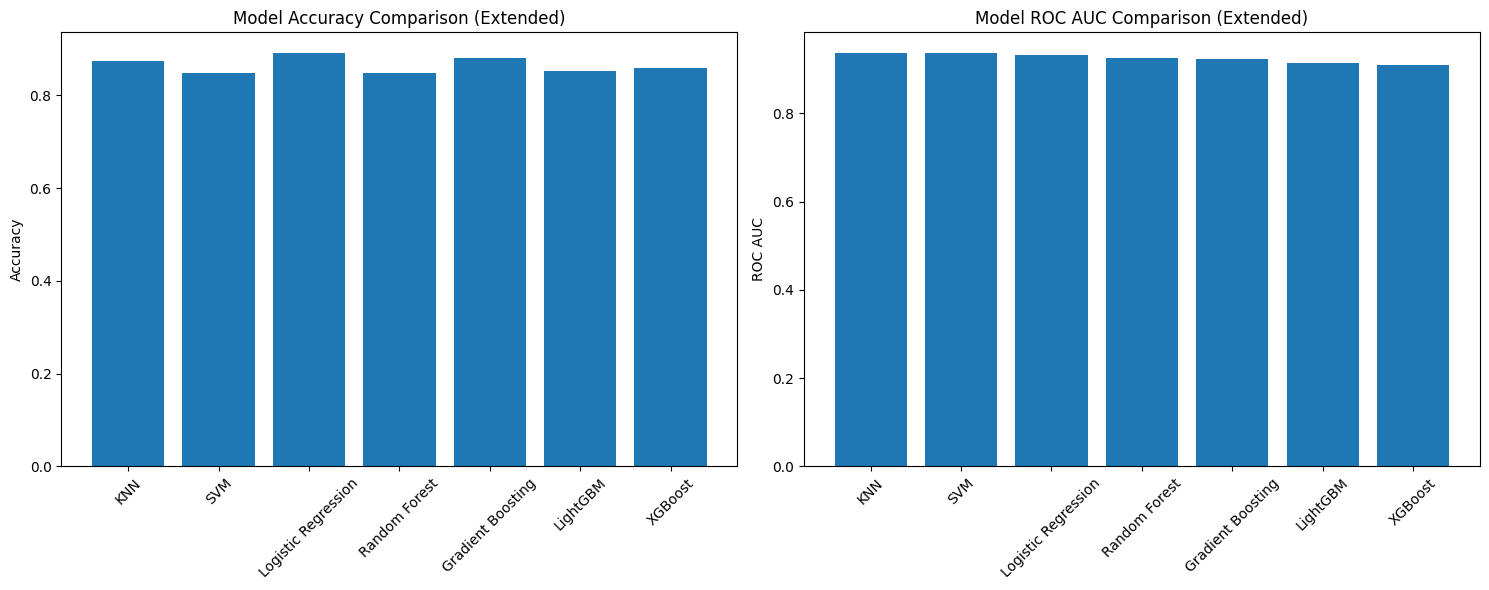

Best performing model: KNN


In [32]:
# 模型性能比较
model_results_extended = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'KNN', 'LightGBM', 'XGBoost'],
    'Accuracy': [accuracy, rf_accuracy, svm_accuracy, gb_accuracy, knn_accuracy, lgb_accuracy, xgb_accuracy],
    'ROC_AUC': [roc_auc, rf_roc_auc, svm_roc_auc, gb_roc_auc, knn_roc_auc, lgb_roc_auc, xgb_roc_auc]
}).sort_values(by='ROC_AUC', ascending=False)

print("Extended Model Performance Comparison:")
print(model_results_extended)

# 可视化扩展比较
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(model_results_extended['Model'], model_results_extended['Accuracy'])
plt.title('Model Accuracy Comparison (Extended)')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(model_results_extended['Model'], model_results_extended['ROC_AUC'])
plt.title('Model ROC AUC Comparison (Extended)')
plt.xticks(rotation=45)
plt.ylabel('ROC AUC')

plt.tight_layout()
plt.savefig("extended_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Best performing model: {model_results_extended.iloc[0]['Model']}")

In [35]:
# 交叉验证评估
models_extended = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='lbfgs', max_iter=2000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0)
}

print("=== 交叉验证结果 ===")
cv_results_extended = {}
for name, model in models_extended.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    cv_results_extended[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }
    print(f"{name} - CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

=== 交叉验证结果 ===
Logistic Regression - CV ROC AUC: 0.9155 (+/- 0.0728)
Random Forest - CV ROC AUC: 0.9228 (+/- 0.0525)
SVM - CV ROC AUC: 0.9154 (+/- 0.0587)
Gradient Boosting - CV ROC AUC: 0.9235 (+/- 0.0401)
KNN - CV ROC AUC: 0.8934 (+/- 0.0703)
LightGBM - CV ROC AUC: 0.9180 (+/- 0.0357)
XGBoost - CV ROC AUC: 0.9166 (+/- 0.0327)


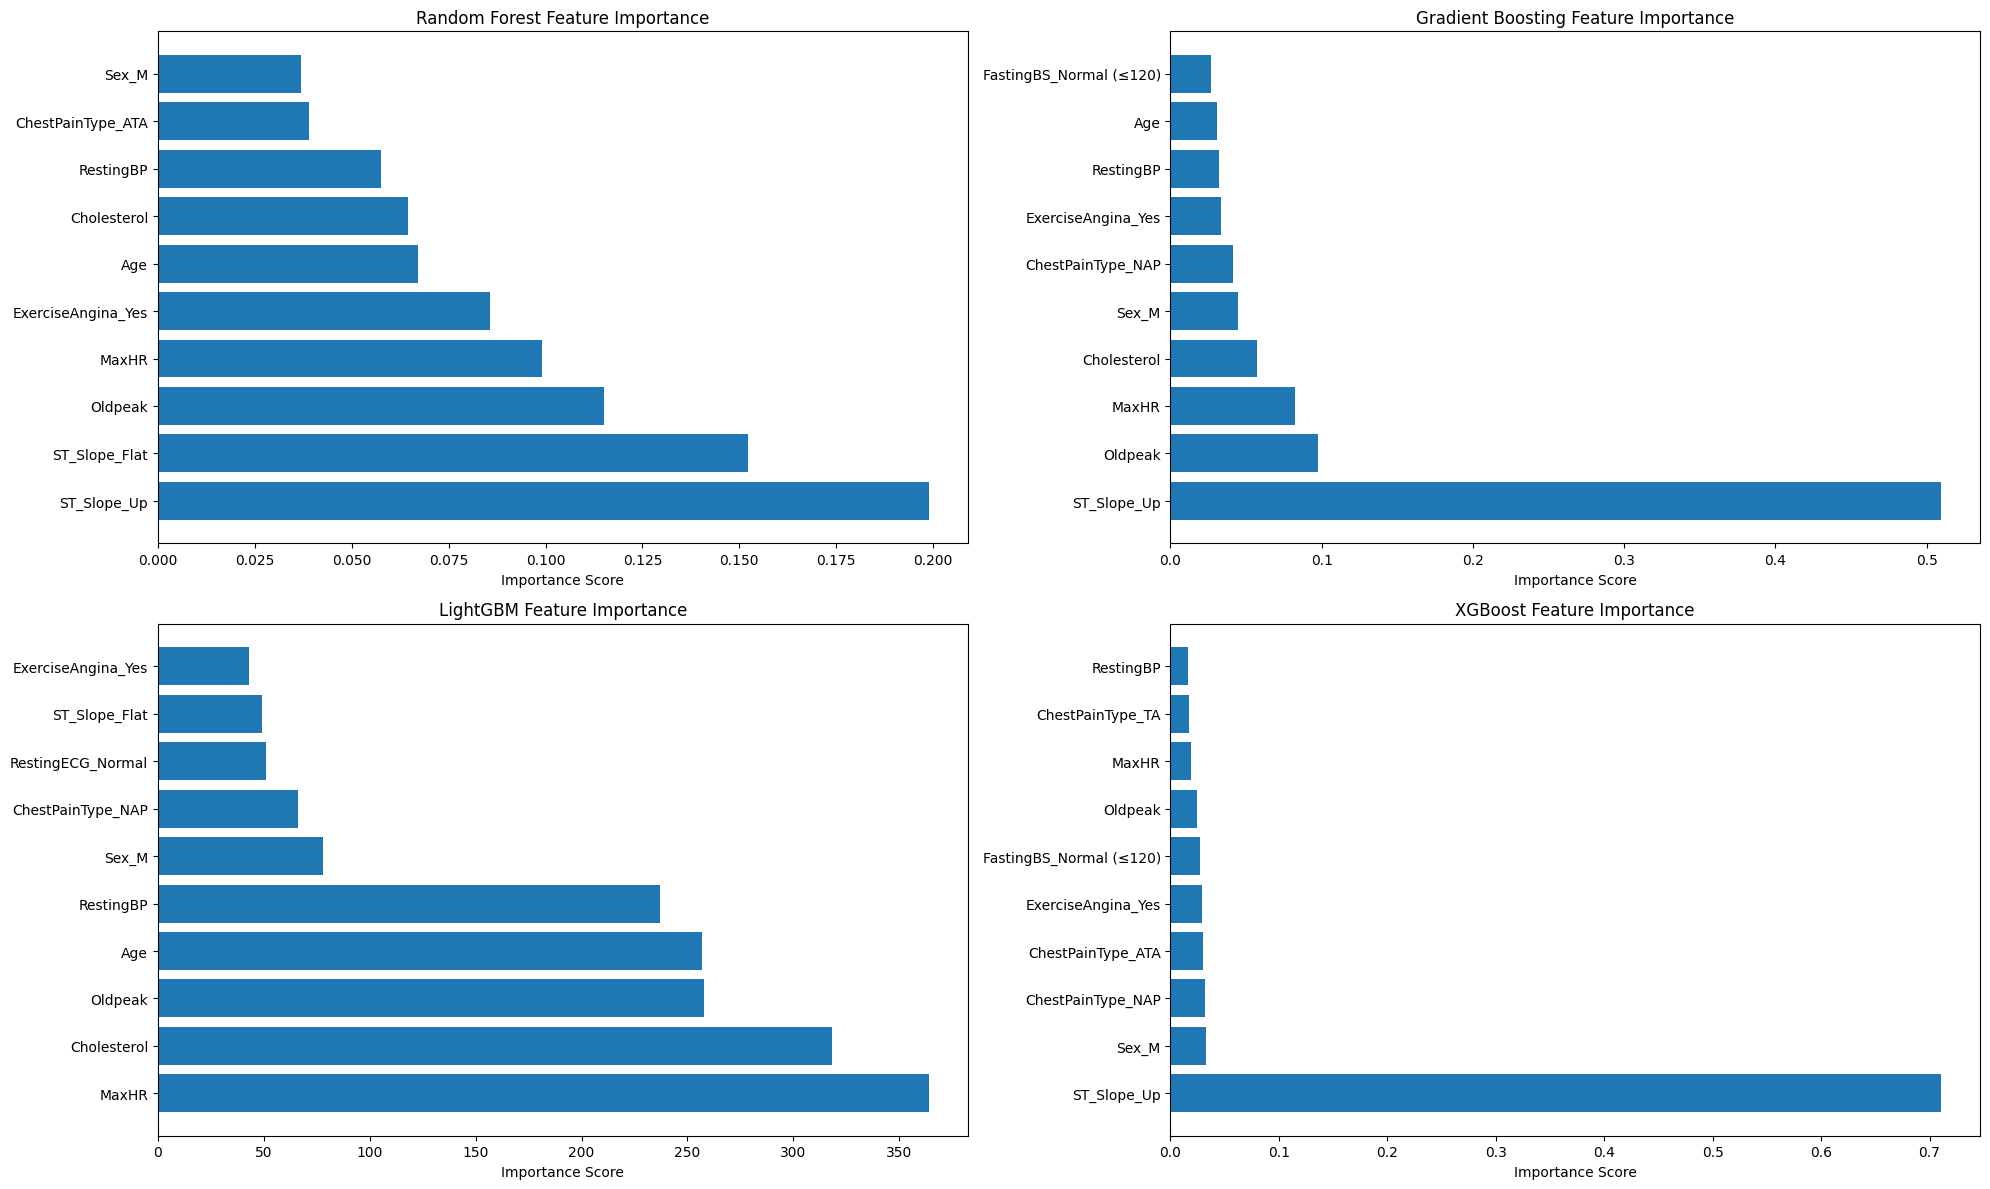

In [34]:
# 特征重要性综合分析
plt.figure(figsize=(20, 12))

# 显示树模型的特征重要性
tree_models = [
    ('Random Forest', rf_importance),
    ('Gradient Boosting', gb_importance),
    ('LightGBM', lgb_importance),
    ('XGBoost', xgb_importance)
]

for i, (name, importance_df) in enumerate(tree_models):
    plt.subplot(2, 2, i + 1)
    top_features = importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.title(f'{name} Feature Importance')
    plt.xlabel('Importance Score')

plt.tight_layout()
plt.savefig("tree_models_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()